# Datavalanche


The goal of our project is to highlight the causes of avalanches which kill around 30 people per year in Switzerland. To do so we plan to use public data on mortal avalanche accidents available on the Schnee- und Lawinenforschung's website, we will also use open weather data in Switzerland.

The notebook will be structured as follow:

    1) Data Wrangling and Exploratory Data Analysis
    2) Map Vizualisations
    3) Causes of avalanches 

## 1) Data Wrangling and Exploratory Data Analysis

### Exploratory data analysis of the SLF deadly avalanche dataset

In [1]:
# import useful librairies

%load_ext autoreload
%autoreload 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import folium
from folium import plugins
%aimport helpers
import calendar
import datetime
import seaborn as sns
import os.path
from math import floor
#import pygrib

The data that is used below (`data/avalanches.csv`) is the data that is published at http://www.slf.ch/praevention/lawinenunfaelle/unfaelle_langj/index_EN

It is obtained through the script `avalanche_data_processor.js`

In [2]:
# Read the slf data
data = pd.read_csv('data/avalanches.csv', parse_dates=['date_posix_ts'], date_parser=helpers.parsedate)
data.head()

,winter,date_posix_ts,canton,community,starting_zone_Y,starting_zone_X,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level
0,2015/16,2016-07-04,VS,Baltschieder,631760,138570,3440,5,E,1,1,2,0,0
1,2015/16,2016-05-05,GR,Flims,737700,197340,2900,6,ESE,1,1,1,1,0
2,2015/16,2016-04-29,VS,Naters,640290,146390,3680,11,SW,1,1,2,1,2
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,781510,135430,2810,3,NE,1,1,1,1,3
4,2015/16,2016-04-19,VS,Orsières,570830,93228,3100,2,NNE,2,1,2,1,3


Let's see how many deadly avalanches occurred each year during the last 20 years

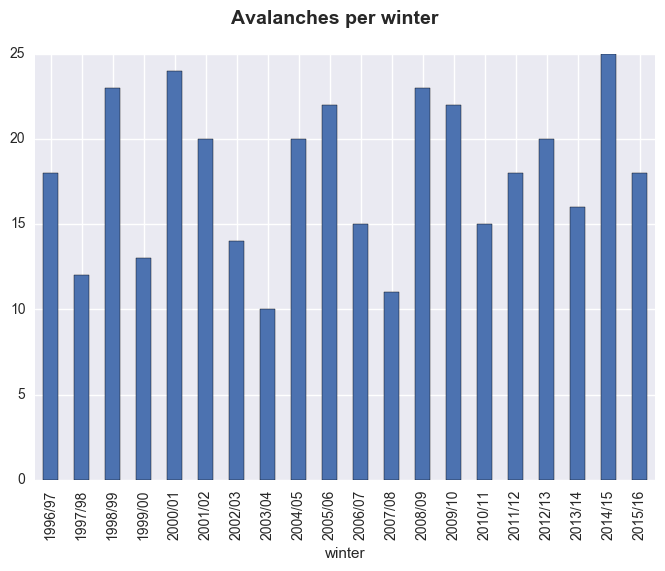

In [3]:
avalanches_per_winter = data.groupby('winter').count()['canton']
fig = plt.figure()
fig.suptitle('Avalanches per winter', fontsize=14, fontweight='bold')
suppress_output = avalanches_per_winter.plot(kind='bar')

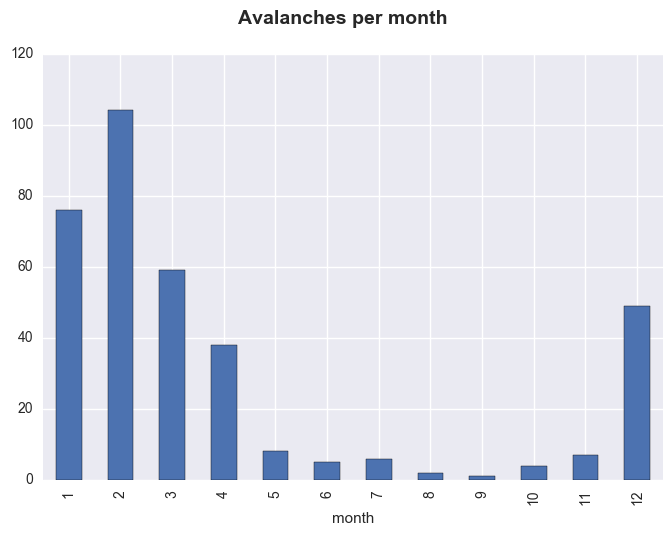

In [4]:
# Plot avalanches per month
data['month'] = data['date_posix_ts'].map(lambda x: x.month)
avalanches_per_month = data.groupby('month').count()['canton']
fig = plt.figure()
fig.suptitle('Avalanches per month', fontsize=14, fontweight='bold')
suppress_output = avalanches_per_month.plot(kind='bar')

In [5]:
# Show the number of avalanches per month per winter
avalanches_per_winter_and_month = data.groupby(['winter', 'month']).count()[['canton']]
avalanches_per_winter_and_month.columns = ['count']
avalanches_per_winter_and_month.head(18)

count
winter  month       
1996/97 1          3
        2         12
        5          1
        7          1
        12         1
1997/98 1          5
        3          2
        4          1
        10         1
        12         3
1998/99 1          3
        2          9
        3          1
        4          2
        6          1
        7          1
        10         1
        12         5



Let's now look at the aspect of the slopes where the avalanches occurred.

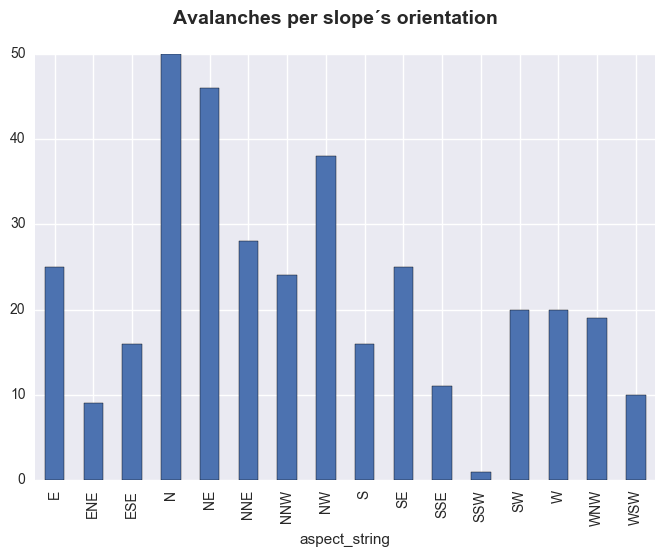

In [6]:
avalanches_per_aspect = data.groupby('aspect_string').count()['canton']
fig = plt.figure()
fig.suptitle('Avalanches per slope´s orientation' , fontsize=14, fontweight='bold')
suppress_output = avalanches_per_aspect.plot(kind='bar')

It seems that north facing slopes are more dangerous. 

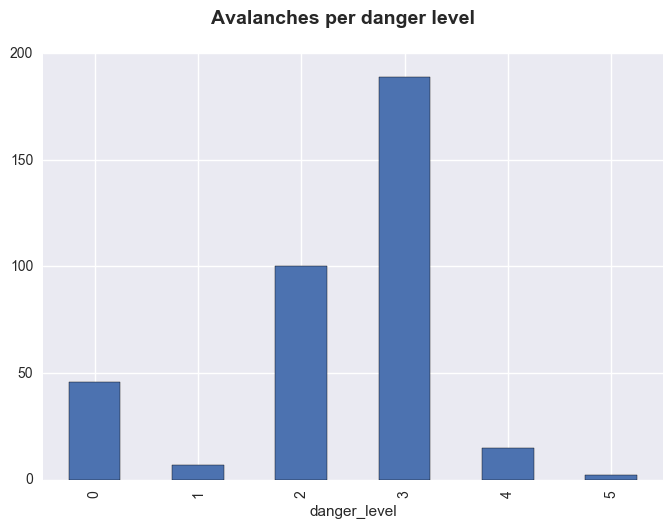

In [7]:
# The danger level is define as follow: http://www.slf.ch/schneeinfo/zusatzinfos/lawinenskala-europa/index_EN
avalanches_per_danger = data.groupby('danger_level').count()['canton']
fig = plt.figure()
fig.suptitle('Avalanches per danger level', fontsize=14, fontweight='bold')
suppress_output = avalanches_per_danger.plot(kind='bar')

Let's see the distribution of avalanche starting point elevation

Mean avalanche start point elevation: 2519.9526462395543


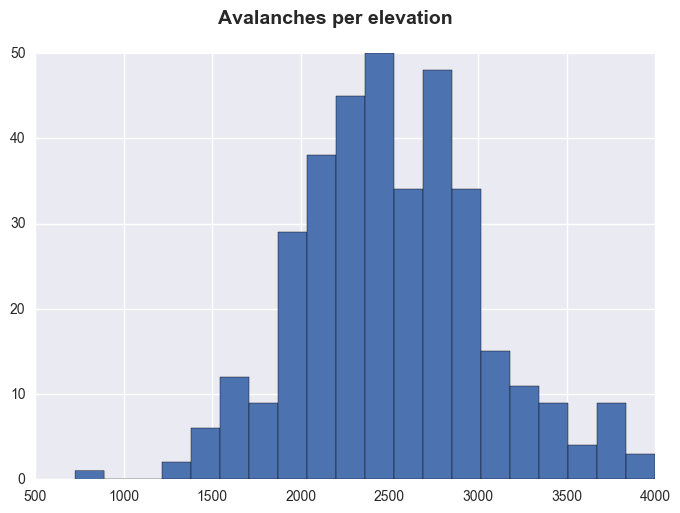

In [8]:
print('Mean avalanche start point elevation:', data['elevation'].mean())
fig = plt.figure()
fig.suptitle('Avalanches per elevation', fontsize=14, fontweight='bold')
data['elevation'].hist(bins=20)

### Observations and Remarks

It is important to note that the avalanches that are present in the dataset are the ones that have caught at least one person.
We can see that on average every winter there are about 18 avalanches which are recorded.
These avalanches occurs mainly between December and April, whith February the worst month, which recorded more than 100 avalanches these last 20 years. We can also see that most avalanches occur on faces that are facing North (N, NE and NW). 
The distribution of the avalanches per elevation looks like a Guassian with mean 2500. Most of the time the danger level is 3 when an avalanch occurs, the fact there are less avalanch with higher risk probably due to the fact that these risks happen less frequently and also people will be more inclined to not go in dangerous places when the risk is high enough. 



## 2) Map Vizualisations

In this second part of the notebook we will do some vizualisations about the data on a map
Note that the markers on the map allow you to view the geographic location in 3D, but it seems like the feature doesn't work quite well.

In [9]:
# Get number of avalanches per canton
missing_cantons = ['ZH', 'ZG', 'SO', 'BS', 'BL', 'SH', 'JU', 'GE', 'NE','TG', 'AR', 'AG']
avalanches_per_canton = data.groupby('canton').count()[['winter']]
avalanches_per_canton.columns = [['count']]
# Apply a log scale
avalanches_per_canton['count'] = avalanches_per_canton['count'].apply(lambda x: 0 if x == 0 else np.log10(x))
avalanches_per_canton = avalanches_per_canton.append(pd.DataFrame({'count':0}, index=missing_cantons))
avalanches_per_canton.reset_index(inplace=True)

In [10]:
# Change the stupid coordinate system in latitude/longitude
for i in data.index:
    x = data.starting_zone_X[i]
    y = data.starting_zone_Y[i]
    lat = helpers.CHtoWGSlat(x, y)
    lng = helpers.CHtoWGSlng(x, y)
    data.set_value(i, 'lat', lat)
    data.set_value(i, 'lon', lng)
    
data.drop(['starting_zone_X','starting_zone_Y'], axis=1, inplace=True)

In [11]:
# Count the number of avalanches per community
d2 = data[['community', 'lat', 'lon']]
cnt = d2.groupby('community').count()[['lat']]
cnt.columns = ['count']
avalanches_per_community = pd.concat([d2.groupby('community').first(), cnt], axis=1)
avalanches_per_community.head()

,lat,lon,count
community,,,
Adelboden,46.447069,7.511086,7
Aeschi bei Spiez,46.595959,7.768668,1
Airolo,46.565699,8.544159,1
Alt St Johann,47.200112,9.256064,1
Altstätten,47.287387,9.511861,1


In [12]:
topo_path = r'ch-cantons.topojson.json'
# Create map with log number of avalanches per canton 
av_per_canton_map = folium.Map(location=[46.8, 8.239], zoom_start=8)
av_per_canton_map.choropleth(geo_path = topo_path, data=avalanches_per_canton,
                     columns=['canton', 'count'], 
                     key_on='feature.id',
                     fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
                     threshold_scale=[0, 0.5, 1, 1.5, 2, 2.5], 
                     topojson='objects.cantons')
helpers.addMarker(avalanches_per_community, av_per_canton_map, 30)

__Avalanches per canton__

The markers are 30 places that had the most number of deadly avalanches the last 20 years 

In [13]:
av_per_canton_map

In [14]:
# Create a heat_map of avalanches
avalanches_heat_map = folium.Map(location=[46.8, 8.239], zoom_start=8, tiles='Mapbox Bright', )
avalanches_heat_map.choropleth(geo_path = topo_path, topojson='objects.cantons', fill_opacity=0.3, line_opacity=0.7), 
avalanches_heat_map_vals = avalanches_per_community.as_matrix()
avalanches_heat_map.add_children(plugins.HeatMap(avalanches_heat_map_vals, radius = 17))
helpers.addMarker(avalanches_per_community, avalanches_heat_map)


__Avalanches heat map__

The markers correspond to the 10 places with most number of avalanches

In [15]:
avalanches_heat_map

### Observations and Remarks

Most of the avalanches happen in the Bern, Valais and Grison canton. This is not too surprising since the Alpes are situated in those canton.
From those three canton the highest density of avalanches happens in Valais.

## Meteorological data

Now we do the same for the meteo data. The data comes from the European Centre for Medium-Range Weather Forecasts (ECMWF), and more specifically from a dataset called [ERA-Interim](http://www.ecmwf.int/en/research/climate-reanalysis/era-interim). We have the data for 6 parameters (Temperature, Wind, Snowfall, Snow depth, Snow density, Sunshine duration) for each avalanche starting point in the SLF dataset, from November 1st 1996 to October 31st 2016. The code to request the data can be found in all_requests.py. It returns files in the binary grib format, which then have to be translated to a usable format and pre-processed in several aspects. This is done in the pre_processing.py file.

In [16]:
#read the meteorological data
meteo_data = pd.read_pickle('./data/pickle/meteo_data_batch_1.pkl')
for i in range(2, 10):
    path = './data/pickle/meteo_data_batch_'+str(i)+'.pkl'
    if(os.path.isfile(path)):
        meteo_data = meteo_data.append(pd.read_pickle(path))
#fix the index
meteo_data = meteo_data.set_index([list(range(0, meteo_data.shape[0]))])

In [17]:
#we don't want to have two datapoints with the exact same coordinates
latlons = []
for i in range(0, 359):
    row = i*7305
    lat = meteo_data.loc[row]['Latitude']
    lon = meteo_data.loc[row]['Longitude']
    latlons_exists = False
    while {'lat': lat, 'lon': lon} in latlons:
        lat += 1e-4
        lon += 1e-4
        latlons_exists = True
    if latlons_exists:
        for j in range(row, row+7305):
            meteo_data.set_value(j, 'Latitude', lat)
            meteo_data.set_value(j, 'Longitude', lon)
    latlons.append({'lat': lat, 'lon': lon})

### Some data exploration

Let's look at a few of the features by day of year, month and winter

In [18]:
nb_places = meteo_data.groupby(['Latitude', 'Longitude']).mean().shape[0]
#since we're going to average over everything, we might as well drop the coordinates
meteo_data_monthly = meteo_data.copy().drop(['Latitude', 'Longitude'], axis=1)
#get rid of the day
meteo_data_monthly['Date'] = meteo_data_monthly['Date'].map(lambda x: datetime.datetime(x.year, x.month, 1))
#group by month, averaging most of the parameters but summing the snowfall and sunshine duration,
#and averaging them by locations
agg_functions = {}
agg_functions.update(dict.fromkeys(meteo_data_monthly.columns.drop(['Date', 'Sunshine duration', 'Snowfall']), 'mean'))
agg_functions.update(dict.fromkeys(['Sunshine duration', 'Snowfall'], lambda x: x.sum()/nb_places))
meteo_data_monthly = meteo_data_monthly.groupby('Date', as_index=False).agg(agg_functions)

In [19]:
#replace the date by the month and the winter, respectively
meteo_data_month = meteo_data_monthly.copy()
#keep only the month
meteo_data_month['Date'] = meteo_data_month['Date'].map(lambda x: x.month)
#sort by month
meteo_data_month.sort_values(by='Date', inplace=True)
#replace the month by its name
meteo_data_month['Date'] = meteo_data_month['Date'].map(lambda x: calendar.month_name[x])
#group by month
meteo_data_month = meteo_data_month.groupby('Date', sort=False).mean()

meteo_data_winter = meteo_data_monthly.copy()
#replace the date by the winter it belongs to
meteo_data_winter['Date'] = meteo_data_winter['Date'].map(lambda x: helpers.date_to_winter(x))
agg_functions.update(dict.fromkeys(['Sunshine duration', 'Snowfall'], 'sum'))
#group by winter and drop the first and the last since the data isn't complete
meteo_data_winter = meteo_data_winter.groupby('Date').agg(agg_functions).drop(['1996-1997', '2016-2017'])

In [20]:
meteo_data_daily = meteo_data.copy()
meteo_data_daily['Day of year'] = meteo_data_daily['Date'].map(lambda x: x.dayofyear)
meteo_data_daily = meteo_data_daily.groupby('Day of year', as_index=False).mean()

Let's plot the average snow depth, first by day of the year, then month and then winter

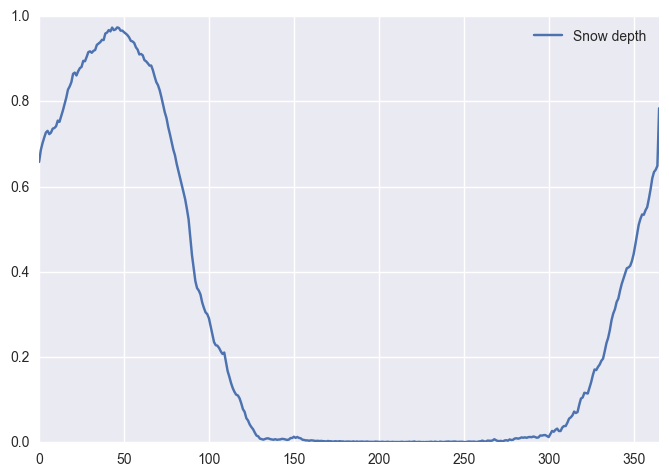

In [21]:
suppress_output = meteo_data_daily.plot(y='Snow depth')

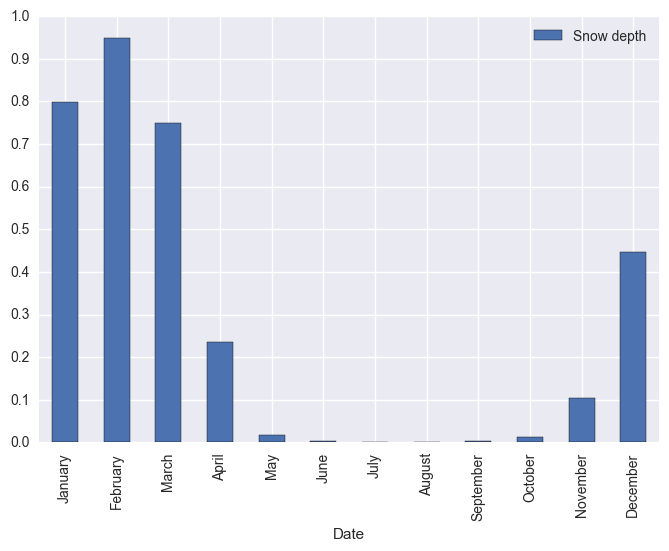

In [22]:
sns.set_style('darkgrid')
suppress_output = meteo_data_month.plot(y='Snow depth', yticks=np.arange(0, 1.1, 0.1), kind='bar')

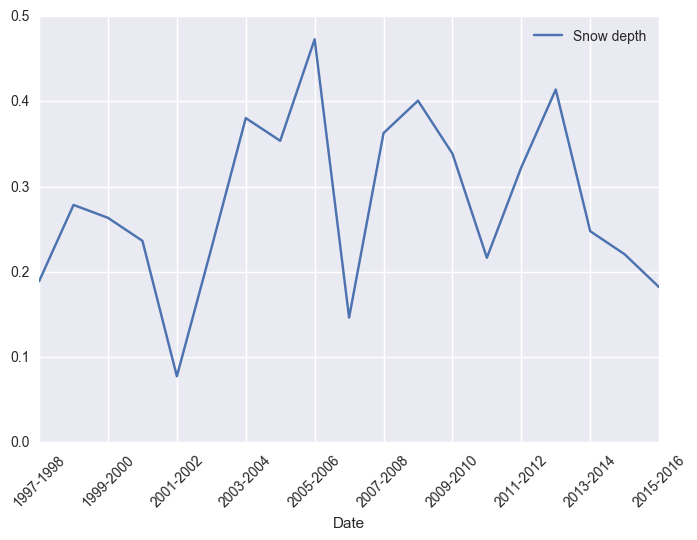

In [23]:
ax = meteo_data_winter.plot(y='Snow depth', yticks=np.arange(0, 0.51, 0.1))

suppress_output = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

Sunshine duration

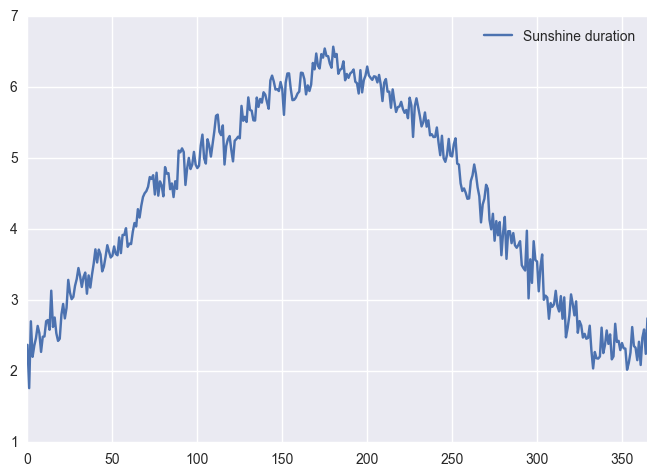

In [24]:
suppress_output = meteo_data_daily.plot(y = 'Sunshine duration')

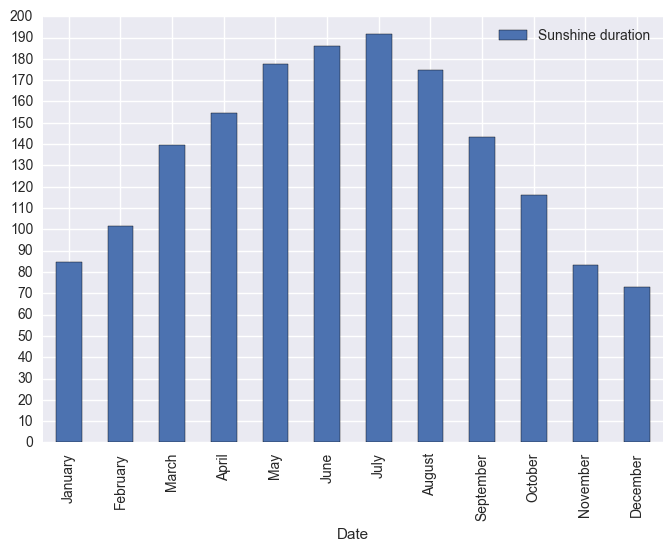

In [25]:
suppress_output = meteo_data_month.plot(y='Sunshine duration', yticks=range(0, 201, 10), kind='bar')

No big surprise there. At least the data seems to make some sort of sense.

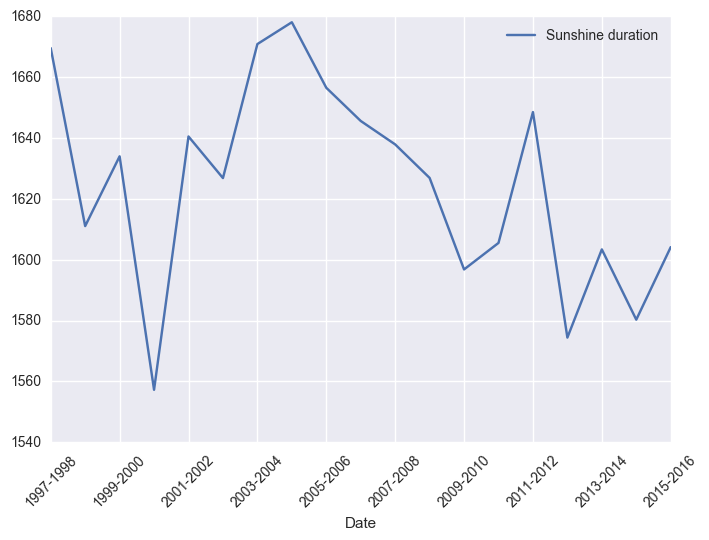

In [26]:
ax = meteo_data_winter.plot(y='Sunshine duration')
suppress_output = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

Temperature

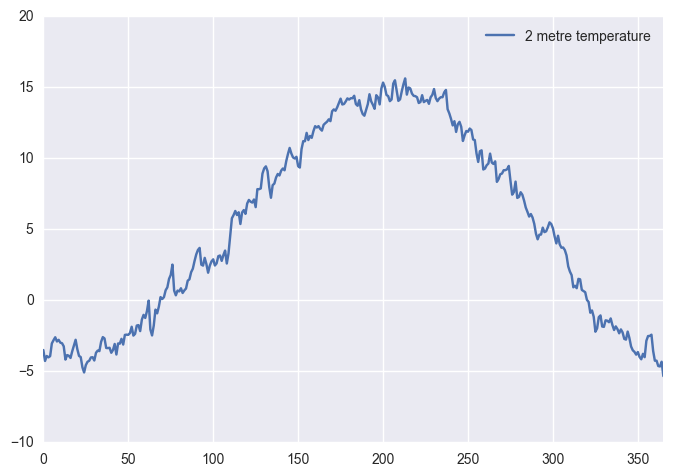

In [27]:
suppress_output = meteo_data_daily.plot(y='2 metre temperature')

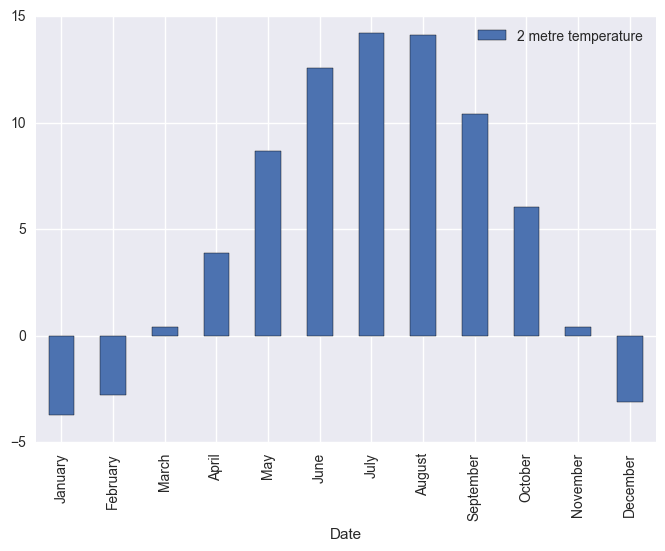

In [28]:
suppress_output = meteo_data_month.plot(y='2 metre temperature', kind='bar')

And for the winters.

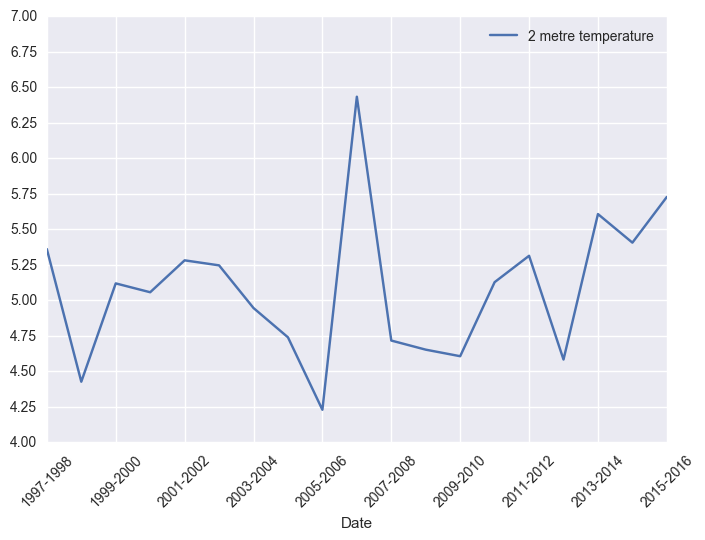

In [29]:
ax = meteo_data_winter.plot(y='2 metre temperature', yticks=np.arange(4, 7.1, 0.25))
suppress_output = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

Wind

In [30]:
def wind_norm_in_kmh(u_component, v_component):
    return 3.6*(u_component**2+v_component**2)**0.5

In [31]:
#compute the norm and convert it to km/h
meteo_data_daily['Wind norm'] = wind_norm_in_kmh(meteo_data_daily['10 metre U wind component'], meteo_data_daily['10 metre V wind component'])
meteo_data_month['Wind norm'] = wind_norm_in_kmh(meteo_data_month['10 metre U wind component'], meteo_data_month['10 metre V wind component'])
meteo_data_winter['Wind norm'] = wind_norm_in_kmh(meteo_data_winter['10 metre U wind component'], meteo_data_winter['10 metre V wind component'])

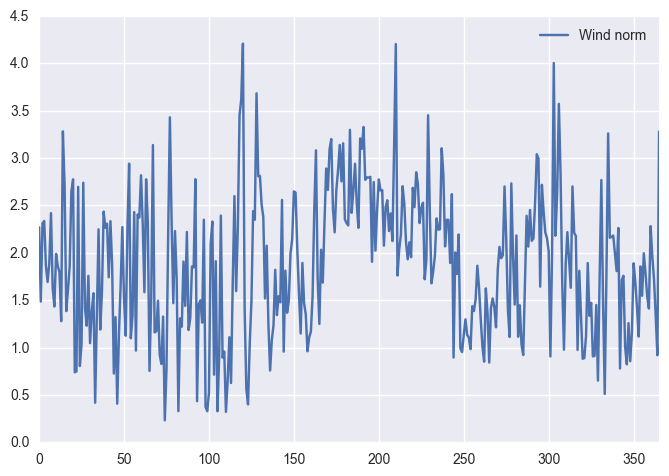

In [32]:
suppress_output = meteo_data_daily.plot(y = 'Wind norm')

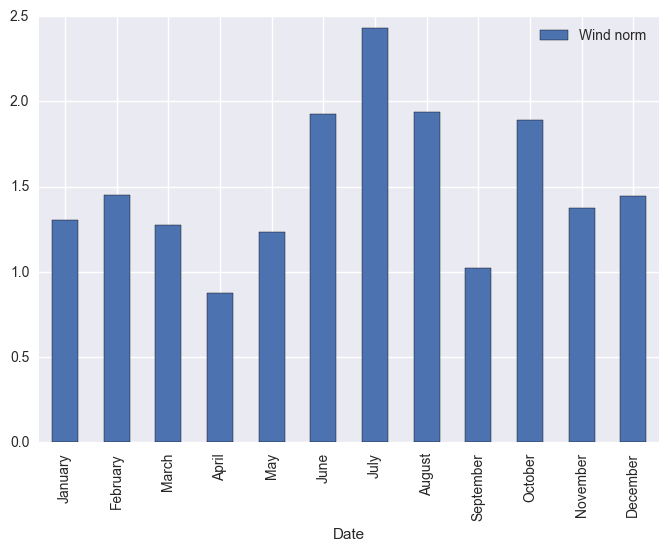

In [33]:
suppress_output = meteo_data_month.plot(y = 'Wind norm', kind='bar')

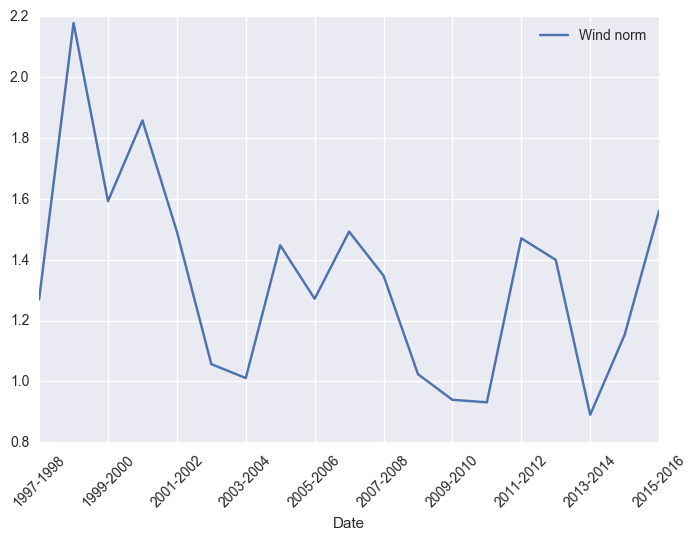

In [34]:
ax = meteo_data_winter.plot(y = 'Wind norm')
suppress_output = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

## Bringing the datasets together

Now that we know a little more about our data, let's try to see what insight we can gain by joining our datasets together. First we need to prepare our data a little bit more, namely changing the coordinates in the avalanches dataset so they match the ones in the meteo and we can join them.

In [35]:
data_with_ts = data.copy()
data_with_ts['date_posix_ts'] = data_with_ts['date_posix_ts'].map(lambda date: date.timestamp())

In [36]:
latlons = []
for i in range(0, data_with_ts.shape[0]):
    lat = 5e-4+floor(1000*data_with_ts.loc[i]['lat'])/1000
    lon = 5e-4+floor(1000*data_with_ts.loc[i]['lon'])/1000
    while {'lat': lat, 'lon': lon} in latlons:
        lat += 1e-4
        lon += 1e-4
    data_with_ts.set_value(i, 'lat', lat)
    data_with_ts.set_value(i, 'lon', lon)
    latlons.append({'lat': lat, 'lon': lon})

Joins on floats don't work so well, so convert the columns into strings.

In [37]:
meteo_data_str = meteo_data.copy()
meteo_data_str['Latitude'] = meteo_data_str['Latitude'].astype('str')
meteo_data_str['Longitude'] = meteo_data_str['Longitude'].astype('str')
data_with_ts_str = data_with_ts.copy()
data_with_ts_str['lat'] = data_with_ts_str['lat'].astype('str')
data_with_ts_str['lon'] = data_with_ts_str['lon'].astype('str')

In [38]:
merged = meteo_data_str.merge(data_with_ts_str, right_on=['lat', 'lon'], left_on=['Latitude', 'Longitude'])

In [39]:
merged['Avalanche'] = (merged['date_posix_ts'] == merged['Date'].map(lambda x: x.timestamp())).map(int)

In [40]:
merged.drop(['activity', 'victims', 'caught', 'buried', 'danger_level', 'month', 'lat', 'lon', 'aspect_id', 'date_posix_ts', 'winter'], axis=1, inplace=True)

In [41]:
avalanches_df = merged[merged['Avalanche'] == 1]

In [42]:
avalanches_df = avalanches_df[avalanches_df['Snow depth'] != 0]

In [43]:
#compute the 3 day average for the whole dataset
merged2 = merged.copy()
merged2['3 day wind'] = 3.6*(merged2['10 metre U wind component']** 2 + 
                        merged2['10 metre V wind component']** 2)**0.5
df = merged2.rolling(4, min_periods=1).agg({'Snowfall': 'sum', 
                            'Sunshine duration':'sum', 
                            '2 metre temperature':'mean',
                            '3 day wind':'mean'})
d = {"Snowfall":"3 day snowfall",
     "Sunshine duration":"3 day sunshine",
    "2 metre temperature":"3 day temperature"}
df = df.rename(columns = d)
merged2 = None
merged_3day = df.merge(merged, left_index=True, right_index=True)

In [44]:
avalanche_df2 = merged_3day[['3 day snowfall', '3 day sunshine', '3 day temperature', '3 day wind']].merge(avalanches_df, left_index=True, right_index=True)